1. import libraries

In [6]:
#import 
from function import yyplot_k, boruta, search_highly_correlated_variables

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import ARDRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

2. Setting

In [7]:
#random seed
rseed_boruta = 1

In [8]:
#select dataset, monomer, descriptors, perc
data_set = "1&2" #1&2 or 3
monomer = "St" #St or nBA
descriptors = "mechanism_oriented" #mechanism_oriented
perc = 90 #dataset1&2:St=90, nBA=80, dataset3:St=80

3. Run model

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	8
Rejected: 	12
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	8
Rejected: 	12
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	8
Rejected: 	12
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	8
Rejected: 	12
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	6
Rejected: 	13
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	6
Rejected: 	13
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	6
Rejected: 	13
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	6
Rejected: 	13
Iteration: 	16 / 100
Confirmed: 	3
Tentative: 	6
Rejected: 	13
I

C:\Users\81806\miniconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:68: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


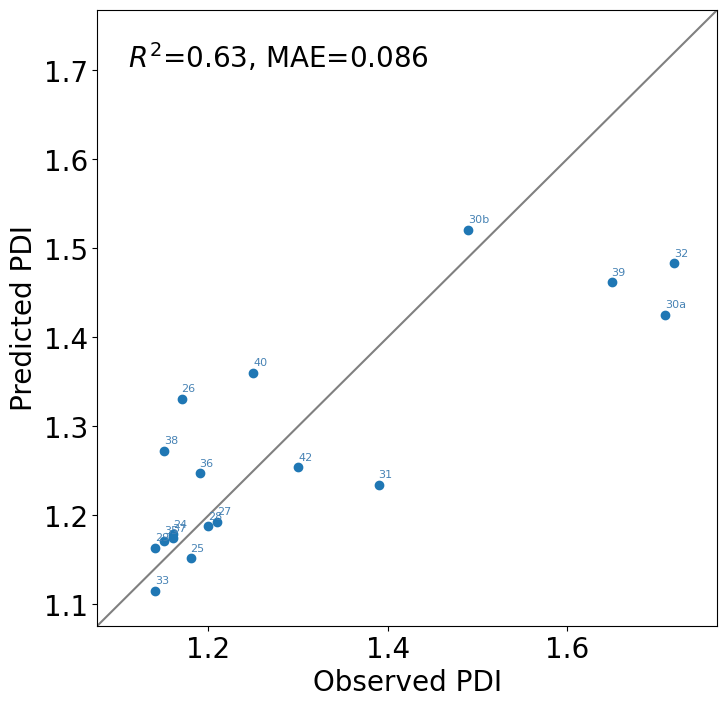

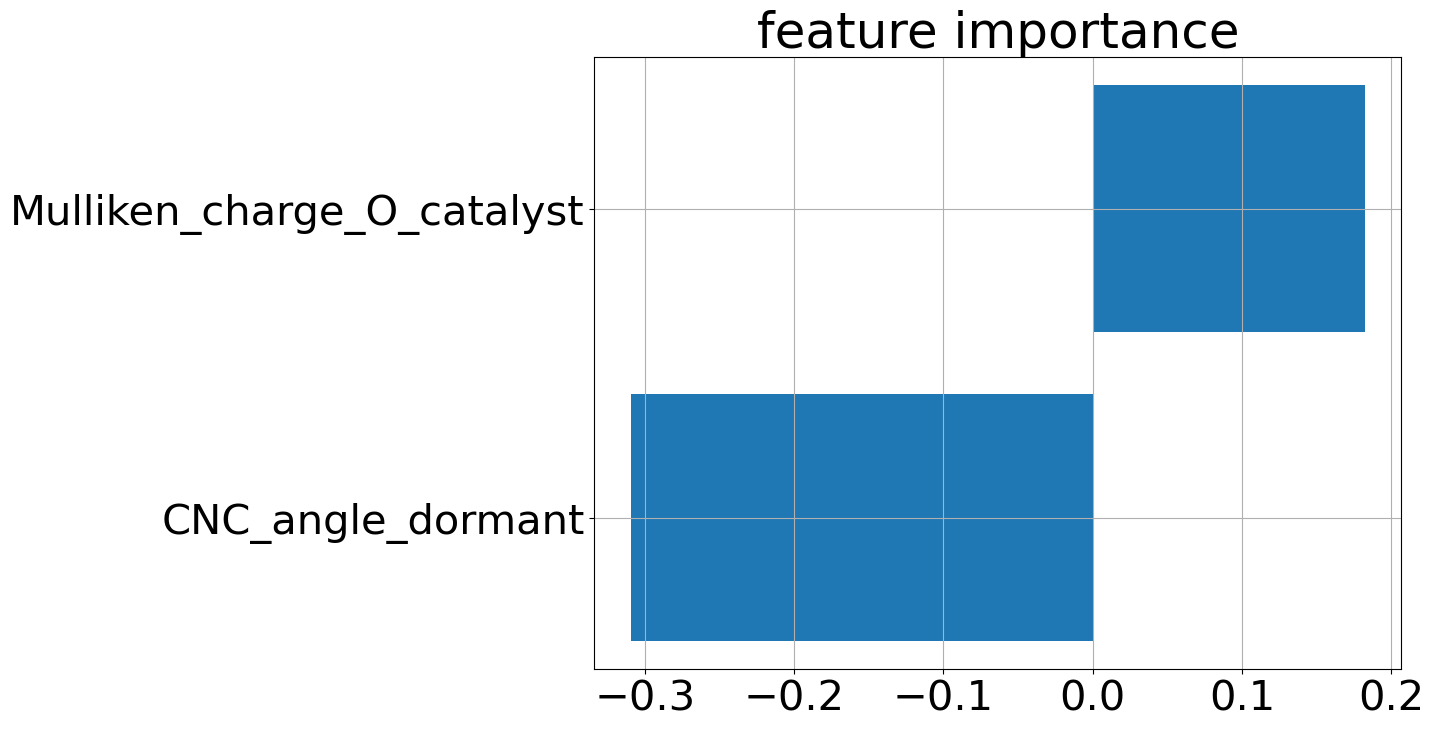

In [9]:
if __name__ == "__main__":
    # file & preprocessing
   try:     
       df_X = pd.read_excel("../data/XY/data_set_{}/data_set_{}_{}_descriptors.xlsx".format(data_set, data_set, descriptors), index_col = 0, sheet_name = monomer) #descriptors select
   except ValueError:
       print(f"Sheet '{monomer}' not found. Loading the first sheet instead.")
       df_X = pd.read_excel("../data/XY/data_set_{}/data_set_{}_{}_descriptors.xlsx".format(data_set, data_set, descriptors), index_col = 0)
    
   df_Y = pd.read_excel("../data/XY/data_set_{}/data_set_{}_SMILES&objective_function.xlsx".format(data_set, data_set), index_col = 0)
    
   df = pd.concat([df_X, df_Y], axis=1)
    
   df.index = df.index.astype("str")
   df.drop(["41"], axis=0, inplace=True) #Select the sample you want to use
   X = df.iloc[:, :len(df_X.columns)]
   # X.drop(["Conversion"], axis=1, inplace=True) #Select the descroptors you want to use
   y = np.log(df["{}_PDI".format(monomer)]-1) # St_PDI or nBA_PDI
   
   #model
   model = ARDRegression(n_iter=1000)
    
   fitting_results = pd.DataFrame(index = X.index, columns = ['pred_y', 'observed_y'])
                
   X = search_highly_correlated_variables(X, 0.8)
   X = boruta(X, y, perc = perc, rseed_boruta = rseed_boruta)
    
   scaler_X = StandardScaler()
   scaler_X.fit(X)
   X_sc = pd.DataFrame(scaler_X.transform(X), index = X.index, columns = X.columns)
    
   model.fit(X_sc, y)
   y_pred = model.predict(X_sc)
    
   coefficients = model.coef_
    
   fitting_results.loc[X.index, 'pred_y'] = np.exp(y_pred) + 1
   fitting_results.loc[X.index, 'observed_y'] = np.exp(y) + 1
    
   dirname = "../result/Fitting"
   os.makedirs(dirname, exist_ok = True)
    
   fitting_results.to_excel(dirname + "/{}_{}_ARD_Fitting_{}_perc={}.xlsx".format(data_set, monomer, descriptors, perc))
    
    
   #valuation index
   r2 = r2_score(fitting_results['observed_y'], fitting_results['pred_y'])
   MAE = mean_absolute_error(fitting_results['observed_y'], fitting_results['pred_y'])
    
   #yy-plot
   yyplot_k(fitting_results['observed_y'], fitting_results['pred_y'])
    
   for i, label in enumerate (fitting_results.index):
       plt.annotate(label, xy = (fitting_results['observed_y'][label], fitting_results['pred_y'][label]), xytext=(0, 5),  # Adjust these values as needed
            textcoords='offset points',size =8, color = "steelblue")
        
   plt.text(0.05, 0.95, r"$R^2$={}, MAE={}".format(round(r2, 2), round(MAE, 3)), transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='left',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    
   plt.savefig(dirname + "/{}_{}_ARD_Fittng_{}_perc={}.jpg".format(data_set, monomer, descriptors, perc))
    
   #feature importance
   plt.figure(figsize = [15, 8])
   plt.rcParams["font.size"] =30
   nonzero_coefficients = [i for i, coef in enumerate(model.coef_) if abs(coef) >  0.002]
   
   X_selected = X.iloc[:, nonzero_coefficients]
   plt.barh(X_selected.columns.ravel(), model.coef_[nonzero_coefficients].ravel())
   plt.grid()
   plt.title("feature importance")
   plt.tight_layout()
    
   plt.savefig(dirname + "/{}_{}_ARD_Fittng_{}_perc={}_feature_importance.jpg".format(data_set, monomer, descriptors, perc))